# SI 370: Natural Language Processing Part 2

Prerequisite: please install the empath package by running the following code block:


In [1]:
!conda install -y empath

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - empath


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    empath-0.89                |             py_1          50 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          50 KB

The following NEW packages will be INSTALLED:

  empath             conda-forge/noarch::empath-0.89-py_1



empath-0.89          | 50 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [14]:
import pandas as pd
import nltk
import numpy as np
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Term frequency-Inverse document frequency (TF-IDF) 

Let's first load the dataset. We will load news articles belonging to four categories: atheism, religion, graphics, and space. This is provided as one of the datasets within scikit-learn.

In [3]:
# select categories
categories = [
    'alt.atheism',
    'comp.graphics',
    'sci.space',
    'talk.religion.misc',
]
print("Loading 20 newsgroups dataset for categories:")
print(categories)

# load the dataset of the following categories
dataset = fetch_20newsgroups(subset='test', categories=categories,
                             shuffle=False, random_state=42)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


Below is the code for cutting down the number of documents for our dataset. Refresh the notebook and run this line if your kernel seems to keep dying due to memory issues.

In [4]:
# for k,V in dataset.items():
#     dataset[k]=V[:300]

In [5]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

1353 documents
4 categories


In [6]:
# get the labels for each article, here which is the article's corresponding category
labels = [categories[x] for x in dataset.target]
true_k = np.unique(labels).shape[0]
print("Samples of labels: ",labels[:10])

Samples of labels:  ['sci.space', 'comp.graphics', 'comp.graphics', 'comp.graphics', 'comp.graphics', 'sci.space', 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


Let's first take a look at a data sample. Each sample is an email document with a specific topic

In [7]:
for i,text in enumerate(dataset.data[:1]):
    print(i,labels[i],text)

0 sci.space From: perky@acs.bu.edu (Melissa Sherrin)
Subject: Re: moon image in weather sat image
Organization: Boston University, Boston, MA, USA
Lines: 14
Originator: perky@acs.bu.edu


I'm afraid I was not able to find the GIFs... is the list 
updated weekly, perhaps, or am I just missing something?

   _______
  (       )
 (_  (     )
   (      )
  (    )  )
 (  (     )
(__________)
 / / / / /
 Melissa Sherrin
 perky@acs.bu.edu



In [8]:
# preprocess the lines using various preprocessing techniques
from nltk import wordpunct_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

S = set(stopwords.words('english'))
preprocessed_data = []
for text in dataset.data:
    
    # regular expressions
    text = re.sub('\S*@\S*\s?', '', text) # for removing emails
    text = re.sub('\s+', ' ', text) # for removing new line characters
    text = re.sub("\'", "", text) # for removing distracting single quotes
    
    # lower case & tokenizing
    words = wordpunct_tokenize(text.lower())
    
    # stopword removal, lemmatizing, & stemming
    words_out = []
    for word in words:
        if word in S:
            continue
        word = lemmatizer.lemmatize(stemmer.stem(word))
        words_out.append(word)
    preprocessed_data.append(' '.join(words_out))

# replace the original data with the preprocessed data
dataset.data = preprocessed_data

Let's change the data into vectors, just as we did in last class.

In [9]:
# bag-of-word vectorizer from last class
vectorizer1 = CountVectorizer(max_features=500)

# fit and transform all articles into vectors
X = vectorizer1.fit_transform(dataset.data)
print("Size of bag-of-word matrix: ",X.shape)

Size of bag-of-word matrix:  (1353, 500)


In [10]:
X

<1353x500 sparse matrix of type '<class 'numpy.int64'>'
	with 66338 stored elements in Compressed Sparse Row format>

Let's now further reduce the dimensions. Before using t-SNE straight away, we will first reduce the dimensions to around 50 using PCA, so that the t-SNE part isn't too computationally heavy.

Note: we use a technique called truncated SVD in place of PCA to reduce dimensions as PCA does not work on sparse data


In [11]:
# NOTE: 
# as PCA does not work on sparse data
svd = TruncatedSVD (n_components=50)
X_truncated = svd.fit_transform(X)
print("Size of truncated matrix: ",X_truncated.shape)

# use t-SNE to further reduce to 2-dimensions
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X_truncated)
print("Size of 2-D matrix: ",X_2d.shape)

Size of truncated matrix:  (1353, 50)
Size of 2-D matrix:  (1353, 2)


Finally, let's plot the code in 2-dimension space.

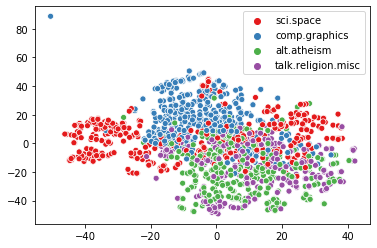

In [12]:
sns.scatterplot(x=X_2d[:,0],y=X_2d[:,1],hue=labels,palette="Set1")

## Exercise 1: try applying the same code using tf-idf instead of plain bag-of-words. See how the visualization results change. (3pts) Do you think tf-idf does a better job here? (1pt)

Size of truncated matrix:  (1353, 50)
Size of 2-D matrix:  (1353, 2)


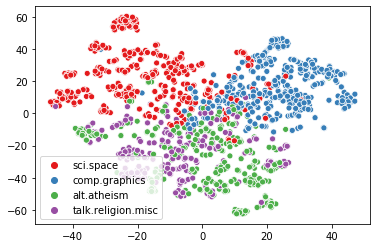

In [16]:
# tf-idf vectorizer
vectorizer1 = TfidfVectorizer(max_features=500)

# fit and transform all articles into vectors
X = vectorizer1.fit_transform(dataset.data)

# as PCA does not work on sparse data
svd = TruncatedSVD (n_components=50)
X_truncated = svd.fit_transform(X)
print("Size of truncated matrix: ",X_truncated.shape)

# use t-SNE to further reduce to 2-dimensions
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X_truncated)
print("Size of 2-D matrix: ",X_2d.shape)

sns.scatterplot(x=X_2d[:,0],y=X_2d[:,1],hue=labels,palette="Set1")

I think ti-idf did a better job here. The 4 groups seem to be much more split than in the bag of words one, they're spread furthter apart from each other and clustered tighter within themselves.

### Similar documents using cosine similarity

An important task in NLP is information retrieval, where the goal is to find relevant documents from a large set. Fancy search engines such as Google are based on solving these problems. 

As we saw earlier, documents represented as tf-idf vectors have similar arrays for those belonging to the same category.
Here, we can further try to find the most similar documents for a document using the cosine similarity metric.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

Say that we want to find the most similar documents to the first one. We first obtain the vector of that document.

In [18]:
idx = 0
text = dataset.data[idx]
vec = X[idx]

Next, we iterate through all other documents and compare that document's vector with our first one. We calculate the cosine similarity scores and add them to a list.

In [19]:
similarities = []
for i in range(len(dataset.data)):
    cos = cosine_similarity(vec,X[i])[0][0]
    similarities.append(cos)

We now select the top-5 most similar documents. We use the argsort function provided by numpy to return the indices of the top-5 documents.

In [29]:
topk = 5
closest = np.argsort(similarities)[-topk:]
print(closest[:5])

[1192  214 1276  544    0]


Now let's print out the most similar documents.

In [30]:
print("Original:")
print(dataset.data[idx])
print('\n')
cnt = 0
for i in reversed(closest):
#     if i!=idx:
    print("No. %d document in similarity: "%cnt)
    cnt+=1
    print(similarities[i],dataset.data[i])
    print('\n')

Original:
: ( melissa sherrin ) subject : : moon imag weather sat imag organ : boston univers , boston , , usa line : 14 origin : im afraid abl find gif ... list updat weekli , perhap , miss someth ? _______ ( ) ( _ ( ) ( ) ( ) ) ( ( ) ( __________ ) / / / / / melissa sherrin


No. 0 document in similarity: 
1.0 : ( melissa sherrin ) subject : : moon imag weather sat imag organ : boston univers , boston , , usa line : 14 origin : im afraid abl find gif ... list updat weekli , perhap , miss someth ? _______ ( ) ( _ ( ) ( ) ( ) ) ( ( ) ( __________ ) / / / / / melissa sherrin


No. 1 document in similarity: 
0.6061440133980907 : ( georg wm turner ) subject : moon imag weather sat imag line : 14 nntp - post - host : bigbang . astro . indiana . edu repli - : ( georg wm turner ) organ : astronomi / indiana univers / home roboscop imag moon caught weather satellit imag earth . appear 0430 - 1500ut ir visual imag earth . gif imag load vmd . cso . uiuc . edu name ci043015 . gif cv043015 . gif 

## Exercise 2: try making your own search engine by typing in a sentence and searching for the most similar documents. (3pts)

- You can change any given sentence to a tf-idf vector by using the .transform() (not fit_transform()) function from the vectorizer.
- e.g., vec = vectorizer.transform(['this is the sample sentence'])

In [45]:
# Please write code here
sentence = 'nvidia graphic'
words = wordpunct_tokenize(sentence)
words_out = [stemmer.stem(lemmatizer.lemmatize(w)) for w in words]
sentence = ' '.join(words_out)

vec = vectorizer1.transform([sentence])

similarities = []
for i in range(len(dataset.data)):
    cos = cosine_similarity(vec,X[i])[0][0]
    similarities.append(cos)
    
topk = 5
closest = np.argsort(similarities)[-topk:]

print("Original:")
print(sentence)
print('\n')
cnt = 0
for i in reversed(closest):
    if i!=idx:
        print("No. %d document in similarity: "%cnt)
        cnt+=1
        print(similarities[i],dataset.data[i])
        print('\n')

Original:
nvidia graphic


No. 0 document in similarity: 
0.6527821015181088 : ( bob fitzsimmon ) subject : : vga graphic librari keyword : c , librari , graphic articl - . .: ogics . 53715 organ : oregon grad . inst . comput scienc eng ., beaverton line : 26 articl ( bill sheppard ) write : > mani high - end graphic card come c sourc code basic graphic > sort thing ( chang color , draw point / line / polygon / fill , etc .). > librari exist gener vga graphic card / chip , hope > public domain ? would purpos compil non - do > oper system run standard pc . > im also interest info public domain commerci graphic librari packag pc vga graphic . im current work realtim applic run pcc non - do kernel need simpl graphic . im sure reentranc graphic librari go issu . suspect ill implement display control server process handl graphic request , queu mailbox , one time . provid suffici frequent display updat believ restrict graphic oper perform server thu constrain access librari singl process avo

## Additional packages for NLP tasks

Lexicons are important features in NLP tasks such as sentiment analysis or document classification. By using lexicon packages, you can get rough features that represent the topics of a document.

Here I will briefly show how to use Empath, a Python package that detects the categories of a document based on lexicon words.

In [46]:
from empath import Empath
lexicon = Empath()

Empath works by inputting a sentence into the lexicon.analyze() function.

In [47]:
sentence = 'he hit the other person'
print(lexicon.analyze(sentence))

{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'money': 0.0, 'wedding': 0.0, 'domestic_work': 0.0, 'sleep': 0.0, 'medical_emergency': 0.0, 'cold': 0.0, 'hate': 0.0, 'cheerfulness': 0.0, 'aggression': 0.0, 'occupation': 0.0, 'envy': 0.0, 'anticipation': 0.0, 'family': 0.0, 'vacation': 0.0, 'crime': 0.0, 'attractive': 0.0, 'masculine': 0.0, 'prison': 0.0, 'health': 0.0, 'pride': 0.0, 'dispute': 0.0, 'nervousness': 0.0, 'government': 0.0, 'weakness': 0.0, 'horror': 0.0, 'swearing_terms': 0.0, 'leisure': 0.0, 'suffering': 0.0, 'royalty': 0.0, 'wealthy': 0.0, 'tourism': 0.0, 'furniture': 0.0, 'school': 0.0, 'magic': 0.0, 'beach': 0.0, 'journalism': 0.0, 'morning': 0.0, 'banking': 0.0, 'social_media': 0.0, 'exercise': 0.0, 'night': 0.0, 'kill': 0.0, 'blue_collar_job': 0.0, 'art': 0.0, 'ridicule': 0.0, 'play': 0.0, 'computer': 0.0, 'college': 0.0, 'optimism': 0.0, 'stealing': 0.0, 'real_estate': 0.0, 'home': 0.0, 'divine': 0.0, 'sexual': 0.0, 'fear': 0.0, 'irritability': 0.0, 'superhero': 0.0, 'b

If we change this into vectors, then we can obtain additional features which we can apply to different machine learning tasks.

In [48]:
result = lexicon.analyze(sentence)
arr = np.array([v for v in result.values()])
arr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

## Exercise 3: Get the Empath distributions for the first 5 documents in our dataset (3pts) Do they make sense with the categories (=labels) for each document? 
- It would be a good idea to print out only the categories that have a value larger than 0 (that appeared at least once)

In [65]:
# Please complete the code in this block
for i in range(5):
    text = dataset.data[i]
    words = wordpunct_tokenize(text)
    words_out = [stemmer.stem(lemmatizer.lemmatize(w)) for w in words]
    text = ' '.join(words_out)
    result = lexicon.analyze(text)
    
    arr = np.array([v for v in result.values()])
#     arr_no_0 = []
#     for j in range(len(arr)):
#         if arr[j] != 0.:
#             arr_no_0.append(arr[j])
            
    print('Empath distribution for document ' + str(i) + ': \n')
    print(arr)

Empath distribution for document 0: 

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]
Empath distribution for document 1: 

[0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 3. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Yes, these make sense because the articles are about space and religious and such.

### Please turn in the HTML version of this notebook file on canvas